In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full_lib_1 = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full_lib_1.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df_lib_1 = data_df_full_lib_1[cols].copy()

data_df_full_lib_2 = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib2.csv')
y_cols = list(data_df_full_lib_2.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df_lib_2 = data_df_full_lib_2[cols].copy()

In [3]:
# data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
# y_cols = list(data_df_full.columns[8:])
# cols = y_cols.copy()
# cols.insert(0,'x')
# data_df = data_df_full[cols].copy()
# data_df.head(10)

data_df = pd.concat([data_df_lib_1,data_df_lib_2]).reset_index(drop=True).copy()
data_df

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184245,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,239,0,0,1,167,0,...,0,0,246,5,0,0,183,26,0,0
184246,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,29,211,45,0,44,244,19,1,...,1,1,147,10,0,0,210,30,0,0
184247,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,24,394,13,0,28,389,2,0,...,0,0,388,27,0,0,366,40,0,0
184248,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,49,17,1,0,19,4,0,5,41,...,0,0,88,19,0,0,119,5,0,0


In [4]:
X = data_df['x']
y = data_df[y_cols]

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
# alphabet=['A', 'C', 'D', 'E', 'F',
#           'G', 'H', 'I', 'K', 'L',
#           'M', 'N', 'P', 'Q', 'R',
#           'S', 'T', 'V', 'W', 'Y', '*']


alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [6]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-26 12:39:34.297145: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [9]:
print(N_y)

TiteSeq_01_bin1     5282064
TiteSeq_01_bin2     2420062
TiteSeq_01_bin3     3563327
TiteSeq_01_bin4    13256660
TiteSeq_02_bin1     5094914
                     ...   
TiteSeq_15_bin4      621457
TiteSeq_16_bin1    23064475
TiteSeq_16_bin2     1582135
TiteSeq_16_bin3     3128968
TiteSeq_16_bin4      725998
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [10]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [11]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [12]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=10,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [13]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [14]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [15]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4084)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [16]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 165,825 observations set as training data.
Using 19.9% for validation.
Time to set data: 31.1 sec.


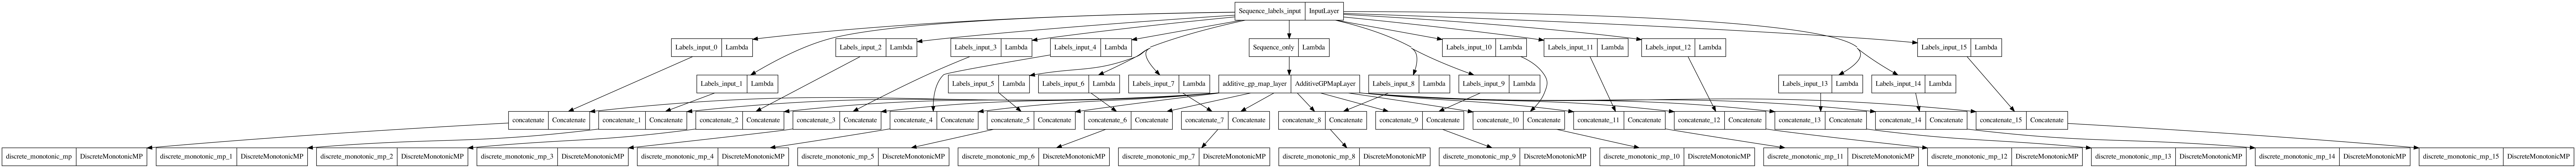

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=False,show_dtype=False,dpi=300,to_file='titeseq_dmr.png')

In [18]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=150,
          batch_size=400,
          try_tqdm = True,
          early_stopping=True,
          early_stopping_patience=5,
          linear_initialization=False)

0epoch [00:00, ?epoch/s]

Epoch 1/150
332/332 [==============================] - 22s 37ms/step - loss: 1211889.1250 - discrete_monotonic_mp_loss: 78109.3984 - discrete_monotonic_mp_1_loss: 81310.2969 - discrete_monotonic_mp_2_loss: 84666.0234 - discrete_monotonic_mp_3_loss: 112163.5078 - discrete_monotonic_mp_4_loss: 83940.9688 - discrete_monotonic_mp_5_loss: 86668.9844 - discrete_monotonic_mp_6_loss: 93504.0859 - discrete_monotonic_mp_7_loss: 85506.4766 - discrete_monotonic_mp_8_loss: 76083.2031 - discrete_monotonic_mp_9_loss: 69283.1250 - discrete_monotonic_mp_10_loss: 66683.9375 - discrete_monotonic_mp_11_loss: 82428.1562 - discrete_monotonic_mp_12_loss: 60071.9570 - discrete_monotonic_mp_13_loss: 45681.2148 - discrete_monotonic_mp_14_loss: 49201.5664 - discrete_monotonic_mp_15_loss: 56585.8594 - I_var: -0.3502 - val_loss: 1018875.3750 - val_discrete_monotonic_mp_loss: 68333.9531 - val_discrete_monotonic_mp_1_loss: 67975.2031 - val_discrete_monotonic_mp_2_loss: 72063.2422 - val_discrete_monotonic_mp_3_loss: 

332/332 [==============================] - 7s 20ms/step - loss: 985268.8125 - discrete_monotonic_mp_loss: 64892.9844 - discrete_monotonic_mp_1_loss: 62536.9453 - discrete_monotonic_mp_2_loss: 65366.7422 - discrete_monotonic_mp_3_loss: 94332.3359 - discrete_monotonic_mp_4_loss: 68688.0156 - discrete_monotonic_mp_5_loss: 74349.1797 - discrete_monotonic_mp_6_loss: 79986.8594 - discrete_monotonic_mp_7_loss: 73628.2969 - discrete_monotonic_mp_8_loss: 71730.3750 - discrete_monotonic_mp_9_loss: 59749.2773 - discrete_monotonic_mp_10_loss: 52584.3047 - discrete_monotonic_mp_11_loss: 66810.5234 - discrete_monotonic_mp_12_loss: 42487.6406 - discrete_monotonic_mp_13_loss: 31944.8984 - discrete_monotonic_mp_14_loss: 33811.5391 - discrete_monotonic_mp_15_loss: 42368.9258 - I_var: -0.0184 - val_loss: 931618.2500 - val_discrete_monotonic_mp_loss: 60650.3711 - val_discrete_monotonic_mp_1_loss: 58530.5430 - val_discrete_monotonic_mp_2_loss: 61186.5352 - val_discrete_monotonic_mp_3_loss: 89108.9141 - val

332/332 [==============================] - 7s 21ms/step - loss: 806554.8750 - discrete_monotonic_mp_loss: 47178.4648 - discrete_monotonic_mp_1_loss: 46624.8555 - discrete_monotonic_mp_2_loss: 50282.1562 - discrete_monotonic_mp_3_loss: 74312.9062 - discrete_monotonic_mp_4_loss: 50329.1328 - discrete_monotonic_mp_5_loss: 54728.2422 - discrete_monotonic_mp_6_loss: 57885.9492 - discrete_monotonic_mp_7_loss: 55824.7812 - discrete_monotonic_mp_8_loss: 56849.7812 - discrete_monotonic_mp_9_loss: 49984.9102 - discrete_monotonic_mp_10_loss: 48708.6953 - discrete_monotonic_mp_11_loss: 63605.9336 - discrete_monotonic_mp_12_loss: 42194.4023 - discrete_monotonic_mp_13_loss: 31525.9277 - discrete_monotonic_mp_14_loss: 33810.5820 - discrete_monotonic_mp_15_loss: 42707.9531 - I_var: -0.0302 - val_loss: 745805.1875 - val_discrete_monotonic_mp_loss: 42820.4219 - val_discrete_monotonic_mp_1_loss: 42399.7500 - val_discrete_monotonic_mp_2_loss: 46008.4219 - val_discrete_monotonic_mp_3_loss: 68671.2344 - val

332/332 [==============================] - 7s 21ms/step - loss: 729926.6250 - discrete_monotonic_mp_loss: 40240.9805 - discrete_monotonic_mp_1_loss: 40149.9531 - discrete_monotonic_mp_2_loss: 44359.9922 - discrete_monotonic_mp_3_loss: 62726.5000 - discrete_monotonic_mp_4_loss: 42893.4141 - discrete_monotonic_mp_5_loss: 47647.7656 - discrete_monotonic_mp_6_loss: 50282.8711 - discrete_monotonic_mp_7_loss: 49902.8555 - discrete_monotonic_mp_8_loss: 50157.2891 - discrete_monotonic_mp_9_loss: 43764.1484 - discrete_monotonic_mp_10_loss: 47226.7930 - discrete_monotonic_mp_11_loss: 62467.3477 - discrete_monotonic_mp_12_loss: 41750.3594 - discrete_monotonic_mp_13_loss: 31078.3340 - discrete_monotonic_mp_14_loss: 33346.9258 - discrete_monotonic_mp_15_loss: 41930.3594 - I_var: -0.0099 - val_loss: 687460.4375 - val_discrete_monotonic_mp_loss: 37765.2852 - val_discrete_monotonic_mp_1_loss: 37652.6094 - val_discrete_monotonic_mp_2_loss: 41654.7305 - val_discrete_monotonic_mp_3_loss: 59058.8281 - val

332/332 [==============================] - 7s 21ms/step - loss: 703232.3125 - discrete_monotonic_mp_loss: 38353.5664 - discrete_monotonic_mp_1_loss: 38301.4336 - discrete_monotonic_mp_2_loss: 42801.8359 - discrete_monotonic_mp_3_loss: 57761.5742 - discrete_monotonic_mp_4_loss: 40891.4375 - discrete_monotonic_mp_5_loss: 45364.2539 - discrete_monotonic_mp_6_loss: 47819.0859 - discrete_monotonic_mp_7_loss: 47720.2266 - discrete_monotonic_mp_8_loss: 47093.0391 - discrete_monotonic_mp_9_loss: 41759.8555 - discrete_monotonic_mp_10_loss: 46162.4023 - discrete_monotonic_mp_11_loss: 61696.0273 - discrete_monotonic_mp_12_loss: 41641.2812 - discrete_monotonic_mp_13_loss: 30993.1855 - discrete_monotonic_mp_14_loss: 33225.1250 - discrete_monotonic_mp_15_loss: 41647.7031 - I_var: -0.0057 - val_loss: 662178.4375 - val_discrete_monotonic_mp_loss: 36070.8320 - val_discrete_monotonic_mp_1_loss: 35974.2969 - val_discrete_monotonic_mp_2_loss: 40254.1094 - val_discrete_monotonic_mp_3_loss: 54597.5312 - val

332/332 [==============================] - 8s 24ms/step - loss: 690504.6250 - discrete_monotonic_mp_loss: 37457.4805 - discrete_monotonic_mp_1_loss: 37359.8359 - discrete_monotonic_mp_2_loss: 42202.6602 - discrete_monotonic_mp_3_loss: 56023.8281 - discrete_monotonic_mp_4_loss: 39889.7969 - discrete_monotonic_mp_5_loss: 44228.5352 - discrete_monotonic_mp_6_loss: 46524.8828 - discrete_monotonic_mp_7_loss: 46448.5312 - discrete_monotonic_mp_8_loss: 45681.7539 - discrete_monotonic_mp_9_loss: 40868.3945 - discrete_monotonic_mp_10_loss: 45401.1367 - discrete_monotonic_mp_11_loss: 61141.5703 - discrete_monotonic_mp_12_loss: 41593.3789 - discrete_monotonic_mp_13_loss: 30962.1426 - discrete_monotonic_mp_14_loss: 33185.4414 - discrete_monotonic_mp_15_loss: 41534.9727 - I_var: -0.0011 - val_loss: 651027.9375 - val_discrete_monotonic_mp_loss: 35284.2227 - val_discrete_monotonic_mp_1_loss: 35111.0898 - val_discrete_monotonic_mp_2_loss: 39715.2500 - val_discrete_monotonic_mp_3_loss: 52967.7539 - val

332/332 [==============================] - 6s 18ms/step - loss: 679931.8125 - discrete_monotonic_mp_loss: 36653.6016 - discrete_monotonic_mp_1_loss: 36483.8398 - discrete_monotonic_mp_2_loss: 41685.6211 - discrete_monotonic_mp_3_loss: 54671.1680 - discrete_monotonic_mp_4_loss: 38954.4180 - discrete_monotonic_mp_5_loss: 43281.3203 - discrete_monotonic_mp_6_loss: 45419.5859 - discrete_monotonic_mp_7_loss: 45367.4062 - discrete_monotonic_mp_8_loss: 44639.1133 - discrete_monotonic_mp_9_loss: 40140.3906 - discrete_monotonic_mp_10_loss: 44855.0312 - discrete_monotonic_mp_11_loss: 60668.8438 - discrete_monotonic_mp_12_loss: 41533.7500 - discrete_monotonic_mp_13_loss: 30933.7578 - discrete_monotonic_mp_14_loss: 33157.0039 - discrete_monotonic_mp_15_loss: 41486.4961 - I_var: 0.0011 - val_loss: 641512.7500 - val_discrete_monotonic_mp_loss: 34621.4609 - val_discrete_monotonic_mp_1_loss: 34366.0938 - val_discrete_monotonic_mp_2_loss: 39301.5586 - val_discrete_monotonic_mp_3_loss: 51831.8750 - val_

332/332 [==============================] - 10s 29ms/step - loss: 670799.1875 - discrete_monotonic_mp_loss: 35926.6602 - discrete_monotonic_mp_1_loss: 35733.6797 - discrete_monotonic_mp_2_loss: 41226.1211 - discrete_monotonic_mp_3_loss: 53463.3672 - discrete_monotonic_mp_4_loss: 38121.4922 - discrete_monotonic_mp_5_loss: 42412.0547 - discrete_monotonic_mp_6_loss: 44385.4922 - discrete_monotonic_mp_7_loss: 44379.0430 - discrete_monotonic_mp_8_loss: 43718.4023 - discrete_monotonic_mp_9_loss: 39661.3867 - discrete_monotonic_mp_10_loss: 44451.8047 - discrete_monotonic_mp_11_loss: 60338.0234 - discrete_monotonic_mp_12_loss: 41490.8359 - discrete_monotonic_mp_13_loss: 30908.9980 - discrete_monotonic_mp_14_loss: 33124.4453 - discrete_monotonic_mp_15_loss: 41457.0078 - I_var: -0.0012 - val_loss: 633623.2500 - val_discrete_monotonic_mp_loss: 34011.2773 - val_discrete_monotonic_mp_1_loss: 33718.7305 - val_discrete_monotonic_mp_2_loss: 38915.8984 - val_discrete_monotonic_mp_3_loss: 50771.8438 - va

332/332 [==============================] - 7s 22ms/step - loss: 666793.5000 - discrete_monotonic_mp_loss: 35553.6836 - discrete_monotonic_mp_1_loss: 35361.9961 - discrete_monotonic_mp_2_loss: 41057.1797 - discrete_monotonic_mp_3_loss: 52750.3555 - discrete_monotonic_mp_4_loss: 37750.3516 - discrete_monotonic_mp_5_loss: 41999.0195 - discrete_monotonic_mp_6_loss: 43904.2383 - discrete_monotonic_mp_7_loss: 43982.0000 - discrete_monotonic_mp_8_loss: 43417.8125 - discrete_monotonic_mp_9_loss: 39654.9766 - discrete_monotonic_mp_10_loss: 44269.5430 - discrete_monotonic_mp_11_loss: 60240.7852 - discrete_monotonic_mp_12_loss: 41452.4805 - discrete_monotonic_mp_13_loss: 30888.2617 - discrete_monotonic_mp_14_loss: 33085.1719 - discrete_monotonic_mp_15_loss: 41425.2070 - I_var: -0.0015 - val_loss: 626470.9375 - val_discrete_monotonic_mp_loss: 33415.4492 - val_discrete_monotonic_mp_1_loss: 33113.7227 - val_discrete_monotonic_mp_2_loss: 38535.6680 - val_discrete_monotonic_mp_3_loss: 49593.1055 - val

332/332 [==============================] - 9s 28ms/step - loss: 658031.0000 - discrete_monotonic_mp_loss: 34786.4180 - discrete_monotonic_mp_1_loss: 34631.2305 - discrete_monotonic_mp_2_loss: 40520.5430 - discrete_monotonic_mp_3_loss: 51472.2578 - discrete_monotonic_mp_4_loss: 36948.1641 - discrete_monotonic_mp_5_loss: 41111.1289 - discrete_monotonic_mp_6_loss: 42975.1562 - discrete_monotonic_mp_7_loss: 43190.5430 - discrete_monotonic_mp_8_loss: 42607.3906 - discrete_monotonic_mp_9_loss: 39141.2227 - discrete_monotonic_mp_10_loss: 43904.0781 - discrete_monotonic_mp_11_loss: 60008.9375 - discrete_monotonic_mp_12_loss: 41402.7891 - discrete_monotonic_mp_13_loss: 30857.0859 - discrete_monotonic_mp_14_loss: 33063.6758 - discrete_monotonic_mp_15_loss: 41409.7031 - I_var: 8.3635e-04 - val_loss: 627337.1875 - val_discrete_monotonic_mp_loss: 33254.4102 - val_discrete_monotonic_mp_1_loss: 33022.6406 - val_discrete_monotonic_mp_2_loss: 38539.1758 - val_discrete_monotonic_mp_3_loss: 49614.7461 - 

332/332 [==============================] - 9s 28ms/step - loss: 653230.8125 - discrete_monotonic_mp_loss: 34334.3398 - discrete_monotonic_mp_1_loss: 34181.6250 - discrete_monotonic_mp_2_loss: 40167.1953 - discrete_monotonic_mp_3_loss: 50770.2383 - discrete_monotonic_mp_4_loss: 36443.4180 - discrete_monotonic_mp_5_loss: 40539.1367 - discrete_monotonic_mp_6_loss: 42500.6523 - discrete_monotonic_mp_7_loss: 42772.1758 - discrete_monotonic_mp_8_loss: 42241.6797 - discrete_monotonic_mp_9_loss: 38972.0273 - discrete_monotonic_mp_10_loss: 43723.9023 - discrete_monotonic_mp_11_loss: 59911.4805 - discrete_monotonic_mp_12_loss: 41375.2266 - discrete_monotonic_mp_13_loss: 30833.2402 - discrete_monotonic_mp_14_loss: 33045.5781 - discrete_monotonic_mp_15_loss: 41418.0898 - I_var: -2.1735e-05 - val_loss: 617132.5000 - val_discrete_monotonic_mp_loss: 32517.7559 - val_discrete_monotonic_mp_1_loss: 32261.1348 - val_discrete_monotonic_mp_2_loss: 37912.6797 - val_discrete_monotonic_mp_3_loss: 48108.8828 -

332/332 [==============================] - 13s 38ms/step - loss: 650613.6250 - discrete_monotonic_mp_loss: 34046.5312 - discrete_monotonic_mp_1_loss: 33891.1484 - discrete_monotonic_mp_2_loss: 39916.7383 - discrete_monotonic_mp_3_loss: 50407.9961 - discrete_monotonic_mp_4_loss: 36068.1562 - discrete_monotonic_mp_5_loss: 40125.4492 - discrete_monotonic_mp_6_loss: 42236.3086 - discrete_monotonic_mp_7_loss: 42604.8203 - discrete_monotonic_mp_8_loss: 42137.7500 - discrete_monotonic_mp_9_loss: 38960.5547 - discrete_monotonic_mp_10_loss: 43683.7969 - discrete_monotonic_mp_11_loss: 59915.3477 - discrete_monotonic_mp_12_loss: 41371.5508 - discrete_monotonic_mp_13_loss: 30813.6016 - discrete_monotonic_mp_14_loss: 33031.3281 - discrete_monotonic_mp_15_loss: 41401.6719 - I_var: -4.9881e-05 - val_loss: 614911.1250 - val_discrete_monotonic_mp_loss: 32300.4043 - val_discrete_monotonic_mp_1_loss: 32070.2793 - val_discrete_monotonic_mp_2_loss: 37726.4961 - val_discrete_monotonic_mp_3_loss: 47891.3086 

332/332 [==============================] - 17s 52ms/step - loss: 647798.3750 - discrete_monotonic_mp_loss: 33811.5508 - discrete_monotonic_mp_1_loss: 33698.2852 - discrete_monotonic_mp_2_loss: 39716.5117 - discrete_monotonic_mp_3_loss: 50096.9883 - discrete_monotonic_mp_4_loss: 35794.9805 - discrete_monotonic_mp_5_loss: 39762.8164 - discrete_monotonic_mp_6_loss: 41898.4062 - discrete_monotonic_mp_7_loss: 42316.3867 - discrete_monotonic_mp_8_loss: 41874.9648 - discrete_monotonic_mp_9_loss: 38786.4805 - discrete_monotonic_mp_10_loss: 43596.6641 - discrete_monotonic_mp_11_loss: 59865.9648 - discrete_monotonic_mp_12_loss: 41344.2617 - discrete_monotonic_mp_13_loss: 30794.2246 - discrete_monotonic_mp_14_loss: 33021.3477 - discrete_monotonic_mp_15_loss: 41417.7383 - I_var: 0.0010 - val_loss: 615027.0000 - val_discrete_monotonic_mp_loss: 32228.3555 - val_discrete_monotonic_mp_1_loss: 31985.1797 - val_discrete_monotonic_mp_2_loss: 37647.4805 - val_discrete_monotonic_mp_3_loss: 47789.7383 - val

332/332 [==============================] - 17s 51ms/step - loss: 647673.5000 - discrete_monotonic_mp_loss: 33750.1484 - discrete_monotonic_mp_1_loss: 33650.4219 - discrete_monotonic_mp_2_loss: 39641.9609 - discrete_monotonic_mp_3_loss: 50155.8398 - discrete_monotonic_mp_4_loss: 35687.2266 - discrete_monotonic_mp_5_loss: 39713.5820 - discrete_monotonic_mp_6_loss: 41850.1289 - discrete_monotonic_mp_7_loss: 42321.6523 - discrete_monotonic_mp_8_loss: 42017.9492 - discrete_monotonic_mp_9_loss: 38830.5273 - discrete_monotonic_mp_10_loss: 43563.9492 - discrete_monotonic_mp_11_loss: 59906.7812 - discrete_monotonic_mp_12_loss: 41356.4492 - discrete_monotonic_mp_13_loss: 30787.9785 - discrete_monotonic_mp_14_loss: 33026.3828 - discrete_monotonic_mp_15_loss: 41411.2656 - I_var: -2.9357e-04 - val_loss: 610859.0625 - val_discrete_monotonic_mp_loss: 31923.2305 - val_discrete_monotonic_mp_1_loss: 31726.1699 - val_discrete_monotonic_mp_2_loss: 37391.1992 - val_discrete_monotonic_mp_3_loss: 47296.6719 

Epoch 69/150
332/332 [==============================] - 10s 30ms/step - loss: 644710.8125 - discrete_monotonic_mp_loss: 33545.8516 - discrete_monotonic_mp_1_loss: 33452.5352 - discrete_monotonic_mp_2_loss: 39456.5078 - discrete_monotonic_mp_3_loss: 49802.4961 - discrete_monotonic_mp_4_loss: 35419.1484 - discrete_monotonic_mp_5_loss: 39361.7852 - discrete_monotonic_mp_6_loss: 41491.8359 - discrete_monotonic_mp_7_loss: 42014.1484 - discrete_monotonic_mp_8_loss: 41657.1133 - discrete_monotonic_mp_9_loss: 38606.3203 - discrete_monotonic_mp_10_loss: 43513.9844 - discrete_monotonic_mp_11_loss: 59838.6875 - discrete_monotonic_mp_12_loss: 41336.3906 - discrete_monotonic_mp_13_loss: 30776.7773 - discrete_monotonic_mp_14_loss: 33019.5195 - discrete_monotonic_mp_15_loss: 41416.8242 - I_var: 0.0035 - val_loss: 609312.9375 - val_discrete_monotonic_mp_loss: 31804.6152 - val_discrete_monotonic_mp_1_loss: 31618.3770 - val_discrete_monotonic_mp_2_loss: 37251.1406 - val_discrete_monotonic_mp_3_loss: 471

332/332 [==============================] - 9s 26ms/step - loss: 643018.5625 - discrete_monotonic_mp_loss: 33427.2578 - discrete_monotonic_mp_1_loss: 33335.3828 - discrete_monotonic_mp_2_loss: 39298.4141 - discrete_monotonic_mp_3_loss: 49623.6094 - discrete_monotonic_mp_4_loss: 35264.4141 - discrete_monotonic_mp_5_loss: 39083.2617 - discrete_monotonic_mp_6_loss: 41235.4961 - discrete_monotonic_mp_7_loss: 41856.8672 - discrete_monotonic_mp_8_loss: 41529.2188 - discrete_monotonic_mp_9_loss: 38507.3359 - discrete_monotonic_mp_10_loss: 43494.8281 - discrete_monotonic_mp_11_loss: 59823.9219 - discrete_monotonic_mp_12_loss: 41340.2148 - discrete_monotonic_mp_13_loss: 30766.9414 - discrete_monotonic_mp_14_loss: 33011.9805 - discrete_monotonic_mp_15_loss: 41418.2500 - I_var: 0.0013 - val_loss: 608338.5000 - val_discrete_monotonic_mp_loss: 31749.7422 - val_discrete_monotonic_mp_1_loss: 31564.8691 - val_discrete_monotonic_mp_2_loss: 37146.5977 - val_discrete_monotonic_mp_3_loss: 47081.6289 - val_

332/332 [==============================] - 10s 31ms/step - loss: 642490.2500 - discrete_monotonic_mp_loss: 33404.9336 - discrete_monotonic_mp_1_loss: 33285.1250 - discrete_monotonic_mp_2_loss: 39208.7539 - discrete_monotonic_mp_3_loss: 49571.0234 - discrete_monotonic_mp_4_loss: 35199.1016 - discrete_monotonic_mp_5_loss: 38959.6055 - discrete_monotonic_mp_6_loss: 41169.4453 - discrete_monotonic_mp_7_loss: 41789.3945 - discrete_monotonic_mp_8_loss: 41492.1289 - discrete_monotonic_mp_9_loss: 38502.9883 - discrete_monotonic_mp_10_loss: 43541.5234 - discrete_monotonic_mp_11_loss: 59845.8711 - discrete_monotonic_mp_12_loss: 41335.0977 - discrete_monotonic_mp_13_loss: 30757.6504 - discrete_monotonic_mp_14_loss: 33008.9961 - discrete_monotonic_mp_15_loss: 41417.6055 - I_var: 9.1676e-04 - val_loss: 609636.0000 - val_discrete_monotonic_mp_loss: 31826.2461 - val_discrete_monotonic_mp_1_loss: 31630.0625 - val_discrete_monotonic_mp_2_loss: 37143.1289 - val_discrete_monotonic_mp_3_loss: 47309.0156 -

332/332 [==============================] - 8s 23ms/step - loss: 640675.3750 - discrete_monotonic_mp_loss: 33279.8633 - discrete_monotonic_mp_1_loss: 33139.4727 - discrete_monotonic_mp_2_loss: 39038.0078 - discrete_monotonic_mp_3_loss: 49377.4570 - discrete_monotonic_mp_4_loss: 35031.6719 - discrete_monotonic_mp_5_loss: 38688.3281 - discrete_monotonic_mp_6_loss: 40946.7695 - discrete_monotonic_mp_7_loss: 41644.8789 - discrete_monotonic_mp_8_loss: 41360.9023 - discrete_monotonic_mp_9_loss: 38370.9258 - discrete_monotonic_mp_10_loss: 43455.4961 - discrete_monotonic_mp_11_loss: 59813.9102 - discrete_monotonic_mp_12_loss: 41336.0273 - discrete_monotonic_mp_13_loss: 30755.5156 - discrete_monotonic_mp_14_loss: 33018.2031 - discrete_monotonic_mp_15_loss: 41416.8555 - I_var: 0.0014 - val_loss: 606430.3750 - val_discrete_monotonic_mp_loss: 31632.7363 - val_discrete_monotonic_mp_1_loss: 31418.9238 - val_discrete_monotonic_mp_2_loss: 36917.8789 - val_discrete_monotonic_mp_3_loss: 46898.8789 - val_

332/332 [==============================] - 8s 23ms/step - loss: 640019.3750 - discrete_monotonic_mp_loss: 33232.8203 - discrete_monotonic_mp_1_loss: 33073.1641 - discrete_monotonic_mp_2_loss: 38936.9883 - discrete_monotonic_mp_3_loss: 49339.9805 - discrete_monotonic_mp_4_loss: 34949.4648 - discrete_monotonic_mp_5_loss: 38577.0977 - discrete_monotonic_mp_6_loss: 40892.6992 - discrete_monotonic_mp_7_loss: 41598.3164 - discrete_monotonic_mp_8_loss: 41322.3516 - discrete_monotonic_mp_9_loss: 38332.6484 - discrete_monotonic_mp_10_loss: 43437.0703 - discrete_monotonic_mp_11_loss: 59820.0898 - discrete_monotonic_mp_12_loss: 41324.7539 - discrete_monotonic_mp_13_loss: 30750.6172 - discrete_monotonic_mp_14_loss: 33011.7695 - discrete_monotonic_mp_15_loss: 41418.3867 - I_var: 8.6580e-04 - val_loss: 605137.2500 - val_discrete_monotonic_mp_loss: 31547.7637 - val_discrete_monotonic_mp_1_loss: 31305.1113 - val_discrete_monotonic_mp_2_loss: 36791.5977 - val_discrete_monotonic_mp_3_loss: 46733.9766 - 

332/332 [==============================] - 7s 21ms/step - loss: 641268.9375 - discrete_monotonic_mp_loss: 33300.3672 - discrete_monotonic_mp_1_loss: 33115.4297 - discrete_monotonic_mp_2_loss: 38924.1875 - discrete_monotonic_mp_3_loss: 49451.0469 - discrete_monotonic_mp_4_loss: 34991.6680 - discrete_monotonic_mp_5_loss: 38667.0586 - discrete_monotonic_mp_6_loss: 41012.6445 - discrete_monotonic_mp_7_loss: 41783.7031 - discrete_monotonic_mp_8_loss: 41500.1406 - discrete_monotonic_mp_9_loss: 38522.1797 - discrete_monotonic_mp_10_loss: 43589.1680 - discrete_monotonic_mp_11_loss: 59894.7148 - discrete_monotonic_mp_12_loss: 41334.0000 - discrete_monotonic_mp_13_loss: 30749.7832 - discrete_monotonic_mp_14_loss: 33016.2109 - discrete_monotonic_mp_15_loss: 41415.6484 - I_var: 0.0010 - val_loss: 604829.1250 - val_discrete_monotonic_mp_loss: 31538.4766 - val_discrete_monotonic_mp_1_loss: 31279.3457 - val_discrete_monotonic_mp_2_loss: 36719.6836 - val_discrete_monotonic_mp_3_loss: 46762.7188 - val_

332/332 [==============================] - 6s 19ms/step - loss: 638150.8750 - discrete_monotonic_mp_loss: 33119.6641 - discrete_monotonic_mp_1_loss: 32922.4102 - discrete_monotonic_mp_2_loss: 38722.7422 - discrete_monotonic_mp_3_loss: 49130.4414 - discrete_monotonic_mp_4_loss: 34782.8047 - discrete_monotonic_mp_5_loss: 38300.3477 - discrete_monotonic_mp_6_loss: 40657.5430 - discrete_monotonic_mp_7_loss: 41477.4219 - discrete_monotonic_mp_8_loss: 41130.0703 - discrete_monotonic_mp_9_loss: 38229.5430 - discrete_monotonic_mp_10_loss: 43397.0117 - discrete_monotonic_mp_11_loss: 59793.4648 - discrete_monotonic_mp_12_loss: 41322.1914 - discrete_monotonic_mp_13_loss: 30740.8633 - discrete_monotonic_mp_14_loss: 33010.1836 - discrete_monotonic_mp_15_loss: 41413.0469 - I_var: 1.8215e-04 - val_loss: 604588.3125 - val_discrete_monotonic_mp_loss: 31515.4824 - val_discrete_monotonic_mp_1_loss: 31248.6582 - val_discrete_monotonic_mp_2_loss: 36644.2812 - val_discrete_monotonic_mp_3_loss: 46789.6758 - 

332/332 [==============================] - 6s 19ms/step - loss: 640308.0625 - discrete_monotonic_mp_loss: 33211.8672 - discrete_monotonic_mp_1_loss: 33001.1445 - discrete_monotonic_mp_2_loss: 38747.5195 - discrete_monotonic_mp_3_loss: 49318.4414 - discrete_monotonic_mp_4_loss: 34885.8477 - discrete_monotonic_mp_5_loss: 38440.0625 - discrete_monotonic_mp_6_loss: 40816.4062 - discrete_monotonic_mp_7_loss: 41789.9023 - discrete_monotonic_mp_8_loss: 41429.1367 - discrete_monotonic_mp_9_loss: 38562.5234 - discrete_monotonic_mp_10_loss: 43669.2188 - discrete_monotonic_mp_11_loss: 59919.2461 - discrete_monotonic_mp_12_loss: 41333.2852 - discrete_monotonic_mp_13_loss: 30751.7480 - discrete_monotonic_mp_14_loss: 33015.0039 - discrete_monotonic_mp_15_loss: 41415.4180 - I_var: 0.0045 - val_loss: 603140.0625 - val_discrete_monotonic_mp_loss: 31421.2637 - val_discrete_monotonic_mp_1_loss: 31141.8477 - val_discrete_monotonic_mp_2_loss: 36531.1523 - val_discrete_monotonic_mp_3_loss: 46555.2812 - val_

332/332 [==============================] - 7s 20ms/step - loss: 637553.5625 - discrete_monotonic_mp_loss: 33054.7539 - discrete_monotonic_mp_1_loss: 32820.1953 - discrete_monotonic_mp_2_loss: 38564.6016 - discrete_monotonic_mp_3_loss: 49081.2734 - discrete_monotonic_mp_4_loss: 34673.6133 - discrete_monotonic_mp_5_loss: 38175.5547 - discrete_monotonic_mp_6_loss: 40539.8164 - discrete_monotonic_mp_7_loss: 41488.9766 - discrete_monotonic_mp_8_loss: 41115.0898 - discrete_monotonic_mp_9_loss: 38270.0039 - discrete_monotonic_mp_10_loss: 43441.5859 - discrete_monotonic_mp_11_loss: 59838.1211 - discrete_monotonic_mp_12_loss: 41321.6016 - discrete_monotonic_mp_13_loss: 30744.7773 - discrete_monotonic_mp_14_loss: 33004.8633 - discrete_monotonic_mp_15_loss: 41417.1953 - I_var: 1.6703e-04 - val_loss: 603674.4375 - val_discrete_monotonic_mp_loss: 31477.0078 - val_discrete_monotonic_mp_1_loss: 31189.7363 - val_discrete_monotonic_mp_2_loss: 36512.4570 - val_discrete_monotonic_mp_3_loss: 46704.4922 - 

On test data:


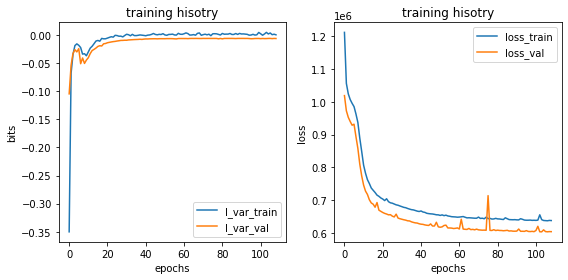

In [19]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model.history['loss'], label='loss_train')
ax.plot(model.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [20]:
model.history['loss'][-1]/1e6

0.6375535625

In [21]:
phi = gpmap.x_to_phi(x_test)

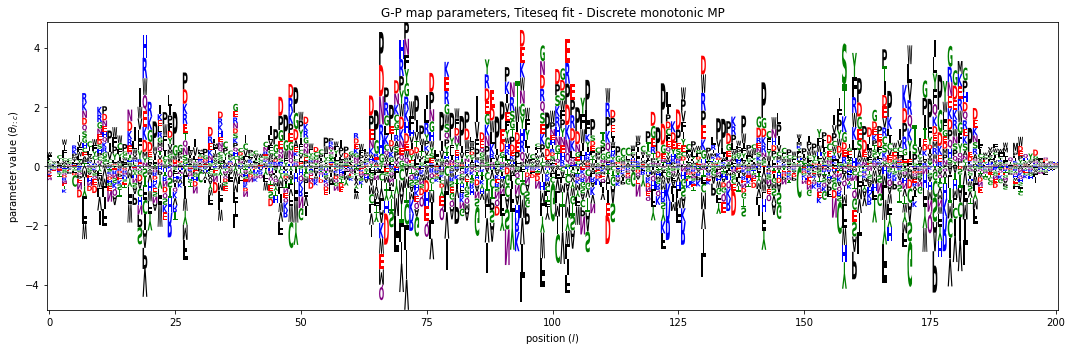

In [22]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete monotonic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DM-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [23]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

In [24]:
theta_raw_df = pd.DataFrame(theta,columns=alphabet)

In [25]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(22)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [26]:

bloom_bind_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    #temp_df['bind_lib1']
    #expr_lib1
    bloom_bind_df.loc[site-1] = temp_df['bind_lib1'].values[0:20]




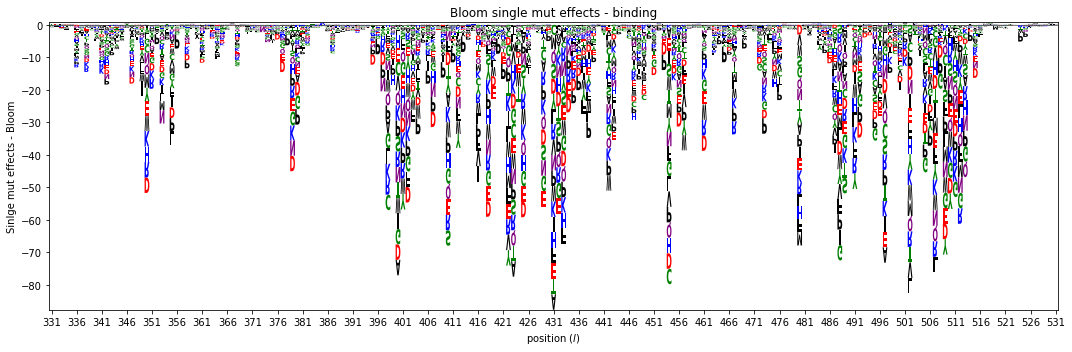

In [27]:
# Get G-P map parameters in matrix form
# theta = np.squeeze(gpmap.weights[1].numpy())

# # Create grid in phi space
# phi_lim = [-5, 3]
# phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# # Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(bloom_bind_df.fillna(0), ax=ax,center_values=False, color_scheme='chemistry')
ax.set_ylabel('Sinlge mut effects - Bloom')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Bloom single mut effects - binding')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

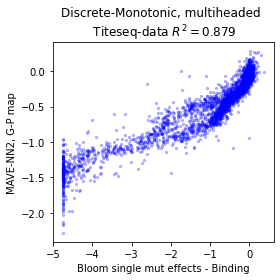

In [28]:
plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_bind_df.fillna(0).values.ravel(), theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
plt.scatter(bloom_bind_df.values, theta_lc_consensus_df.values,s=5,alpha=0.25,color='blue')

# lims = [-5,1]
# plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Binding')
plt.title(f'Discrete-Monotonic, multiheaded \n Titeseq-data $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
#plt.savefig('mavenn_bloom_binding_comparison_DM.png',dpi=200,bbox_inches='tight')

In [29]:
#theta_lc_consensus_df.to_csv('discrete_monotonic_ace2rbd_binding.csv',index=False)

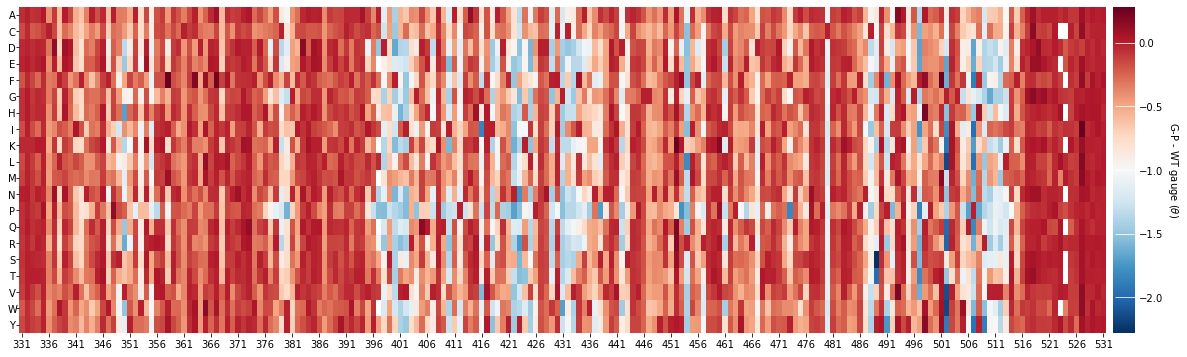

In [30]:

# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[20,6])

# Draw heatmap
ax, cb = mavenn.heatmap(values=theta_lc,
                        alphabet='protein',
                        ax=ax,
                        #gpmap_type='additive',
                        cmap='RdBu_r',
                        cmap_size='2%')

# Style heatmap
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])
#ax.set_xlabel('nucleotide position', labelpad=5)

# Style colorbar
cb.set_label('G-P - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')

In [31]:
np.save('titeseq_gpmap_discrete_monotonic',logo.df.values.ravel())

In [32]:
sortseq_gpmap = np.load('sortseq_gpmap_monotonic_agnostic.npy')
titeseq_gpmap = np.load('titeseq_gpmap_discrete_monotonic.npy')

In [33]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

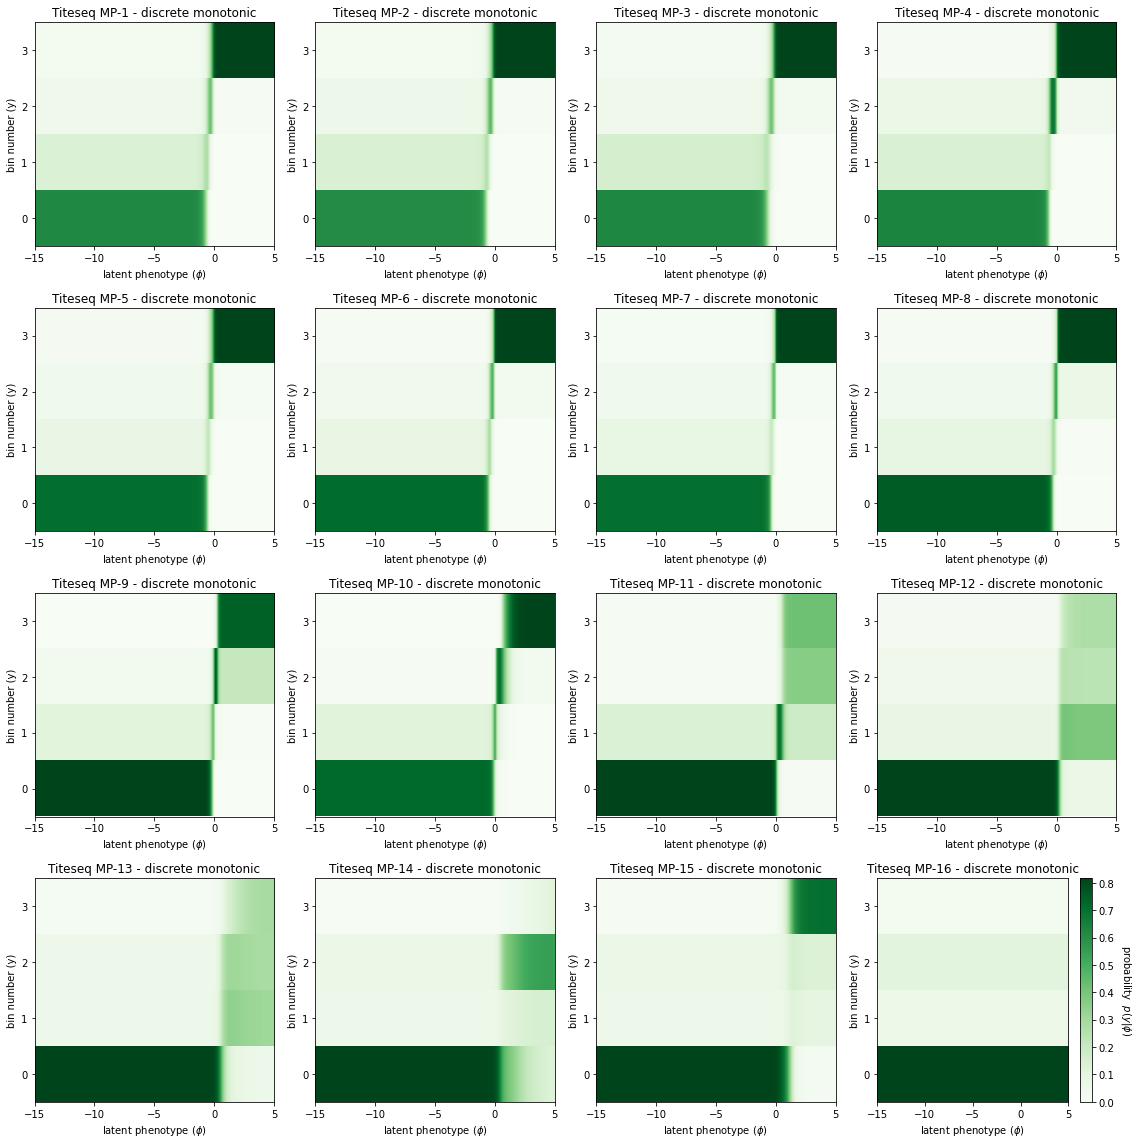

In [35]:
# Create grid in phi space
phi_lim = [-15, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('ace2rbd_discrete_monotonic_MP_fit_to_Titeseq.png',dpi=300,bbox_inches='tight')
